In [1]:
ls

Aggregation.txt              animation.gif             pogo.ipynb
Aggregation.txt12frames.gif  animation.mp4             R15.txt
Aggregation.txt20frames.gif  Compound.txt              R15.txt22frames.gif
Aggregation.txt22frames.gif  Compound.txt22frames.gif  README.md
Aggregation.txt3frames.gif   D31.txt                   spiral20frames.mp4
animation-400.mp4            D31.txt22frames.gif       spiral40frames.mp4
animation-b.mp4              jain40frames.mp4          spiral.txt
animation-c.mp4              jain.txt                  spiral.txt20frames.gif
animation-d.mp4              jain.txt20frames.gif      spiral.txt5frames.gif


In [2]:
import numpy as np
import pandas as pd
import gudhi

In [3]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from matplotlib.collections import PatchCollection

In [4]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification
from sklearn.datasets import make_gaussian_quantiles
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits


from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import metrics

import os.path

In [5]:
%matplotlib inline

#randomized blobs with standard deviation
n = 6
std = np.random.random_sample((n,))
#std = 1
X, y, z = make_blobs(
    n_samples=n*100,
    n_features=2,
    centers=n,
    cluster_std=std,
    center_box=(-10.0, 10.0),
    shuffle=False,
    random_state=42,
    return_centers=True,
)



size=8
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=25, 
            c=y,
            marker="o",
            cmap='tab10',
            norm=None,
            alpha=.7,
            edgecolor="k")

In [6]:
#iris = load_iris()
#X = iris.data
#y = iris.target

In [7]:
filename = 'spiral.txt'
data = np.loadtxt(filename)
y = data[:,2]
print(y.shape)
X = data[:,:2]
print(X.shape)

(312,)
(312, 2)


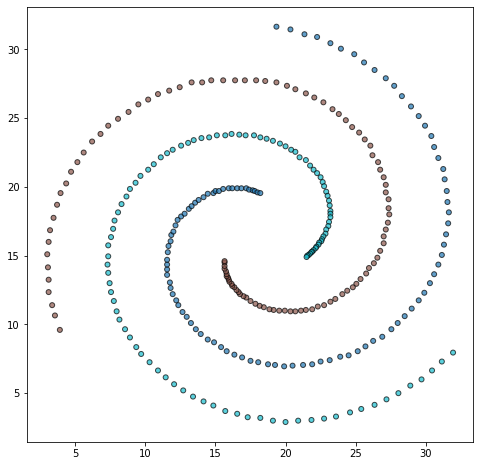

In [8]:
size=8
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=25, 
            c=y,
            marker="o",
            cmap='tab10',
            norm=None,
            alpha=.7,
            edgecolor="k")

In [9]:
rips_complex = gudhi.RipsComplex(points=X,max_edge_length=10)


In [10]:

simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)


#for i in simplex_tree.get_filtration():
#    print(i)
    
print(simplex_tree.num_vertices() , 'vertices')  
print(simplex_tree.num_simplices(), 'simplices')
print('dimension:', simplex_tree.dimension())


312 vertices
18082 simplices
dimension: 1


In [11]:
diag = simplex_tree.persistence()

In [12]:
#simplex_tree.prune_above_filtration(.9)

usetex mode requires TeX.


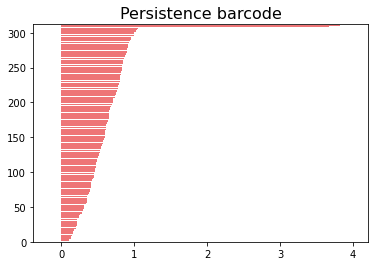

In [13]:
gudhi.plot_persistence_barcode(diag)
plt.show()

In [53]:
#move through list and assign clusters to conected components
point_dict={i:0 for i in range(simplex_tree.num_vertices())}
counter=0
cluster_dict_list = []

for simplex in simplex_tree.get_filtration():
    if len(simplex[0])>1:    
        if all(value > 0 for value in list(point_dict.values())):
            if len(np.unique(np.array(list(point_dict.values())))) == 1:
                print('break')
                print(simplex)
                break


        #if both points are still in cluster 0, assign both to a new cluster
        if point_dict[simplex[0][0]] == 0 and point_dict[simplex[0][1]] == 0:
            counter += 1
            point_dict[simplex[0][0]] = counter
            point_dict[simplex[0][1]] = counter
            #if one point is in cluster 0 and one is not, assign the one in cluster 0 to the existing cluster
        elif point_dict[simplex[0][0]] == 0 and point_dict[simplex[0][1]] != 0:
            point_dict[simplex[0][0]] = point_dict[simplex[0][1]]

            #and vice versa
        elif point_dict[simplex[0][0]] != 0 and point_dict[simplex[0][1]] == 0:
            point_dict[simplex[0][1]] = point_dict[simplex[0][0]]

            #if both points are not in cluster 0 and not in the same cluster, merge clusters to the lower number cluster
        elif point_dict[simplex[0][0]] != 0 and point_dict[simplex[0][1]] != 0 and point_dict[simplex[0][0]] != point_dict[simplex[0][1]]:
            larger_cluster_number = max(point_dict[simplex[0][0]], point_dict[simplex[0][1]])
            smaller_cluster_number = min(point_dict[simplex[0][0]], point_dict[simplex[0][1]])
            for key, value in point_dict.items():
                if value == larger_cluster_number:
                    point_dict[key] = smaller_cluster_number
        cluster_dict_list.append(point_dict.copy())


break
([78, 90], 3.8209946349085606)


In [54]:
len(np.unique(np.array(list(point_dict.values()))))

1

In [55]:
length = len(cluster_dict_list)
length

2190

In [56]:
#convert the simplex tree to a pandas dataframe
df = pd.DataFrame(simplex_tree.get_filtration(), columns=['simplex','distance'])

In [57]:
df = df[:len(cluster_dict_list)]
df

,simplex,distance
0,[0],0.000000
1,[1],0.000000
2,[2],0.000000
3,[3],0.000000
4,[4],0.000000
...,...,...
2185,"[166, 173]",3.309456
2186,"[274, 281]",3.312099
2187,"[257, 263]",3.313608
2188,"[282, 291]",3.313608


In [58]:
#find the gaps between birth/death pairs
df['gaps'] = df['distance'] - df['distance'].shift(1)

In [59]:
#find normalized distance
scaler = MinMaxScaler()
df['normed_distance'] = scaler.fit_transform(df['distance'].values.reshape(-1, 1))

In [60]:
df['normed_gaps'] = df['gaps'] * df['normed_distance']

In [113]:
gap_sum = df['normed_gaps'].sum()
#print(sum)
df['probability_vector'] = df['normed_gaps'] / gap_sum

In [114]:
df['probability_vector'][1:]

1       0.000000
2       0.000000
3       0.000000
4       0.000000
5       0.000000
          ...   
2185    0.002726
2186    0.001590
2187    0.000908
2188    0.000000
2189    0.000454
Name: probability_vector, Length: 2189, dtype: float64

In [115]:
sum(df['probability_vector'][1:])

1.0

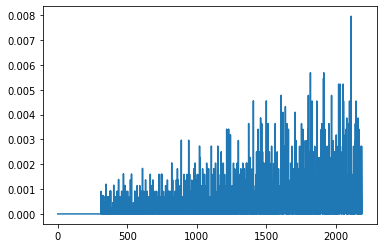

In [116]:
plt.plot(df['probability_vector'])

In [117]:
cluster_dict_list[-2] == cluster_dict_list[-3]

True

In [118]:
marker = 0
print(marker)
for i in range(length):
    if cluster_dict_list[i] == cluster_dict_list[i+1]:
        #assign value in prob vector to prob_vector[marker]
        df.loc[:,'probability_vector'].iloc[marker] += df.loc[:,'probability_vector'].iloc[i]
        df.loc[:,'probability_vector'].iloc[i] = 0
    else:
        marker = i

0


IndexError: list index out of range

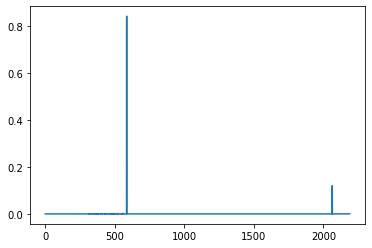

In [119]:
plt.plot(df['probability_vector'])

In [126]:
print(df.loc[:,'probability_vector'][586])
print('percent confidence')

0.8400559430069803
percent confidence


In [101]:
candidates = list(df.nlargest(length,['probability_vector']).index)

In [102]:
candidates

[586,
 2064,
 560,
 524,
 473,
 436,
 491,
 555,
 313,
 328,
 356,
 399,
 520,
 483,
 500,
 344,
 375,
 381,
 367,
 428,
 460,
 552,
 312,
 408,
 414,
 424,
 450,
 489,
 508,
 509,
 540,
 321,
 343,
 359,
 333,
 363,
 394,
 477,
 514,
 2189,
 354,
 364,
 387,
 416,
 429,
 440,
 444,
 466,
 475,
 532,
 547,
 481,
 462,
 405,
 474,
 366,
 516,
 452,
 472,
 433,
 431,
 476,
 386,
 383,
 409,
 423,
 340,
 360,
 471,
 459,
 419,
 488,
 456,
 326,
 418,
 435,
 407,
 420,
 417,
 365,
 448,
 389,
 350,
 446,
 1505,
 1640,
 1503,
 1502,
 1501,
 1500,
 1660,
 1499,
 1641,
 1642,
 1498,
 1497,
 1643,
 1496,
 1644,
 1495,
 1494,
 1493,
 1492,
 1491,
 1645,
 1490,
 1489,
 1504,
 1449,
 1487,
 1506,
 1443,
 1444,
 1445,
 1634,
 1518,
 1635,
 1517,
 1516,
 1515,
 1514,
 1636,
 1637,
 1446,
 1661,
 1513,
 1638,
 1512,
 1511,
 1510,
 1509,
 1508,
 1639,
 1507,
 1488,
 1486,
 1450,
 1460,
 1469,
 1656,
 1468,
 1467,
 1466,
 1465,
 1464,
 1463,
 1657,
 1462,
 1461,
 1459,
 1485,
 1658,
 1458,
 1448,
 145

In [127]:
idx = candidates[0]+1
idx

587

In [128]:
np.array(list(cluster_dict_list[idx].values()))

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [129]:

print('your dataset appears to have', len(np.unique(np.array(list(cluster_dict_list[idx].values())))),'clusters')

your dataset appears to have 3 clusters


In [130]:
true = y
pred = np.array(list(cluster_dict_list[idx].values()))

print(metrics.adjusted_rand_score(true, pred))
print(metrics.silhouette_score(X, pred, metric="sqeuclidean"))

1.0
-0.08671906853344644


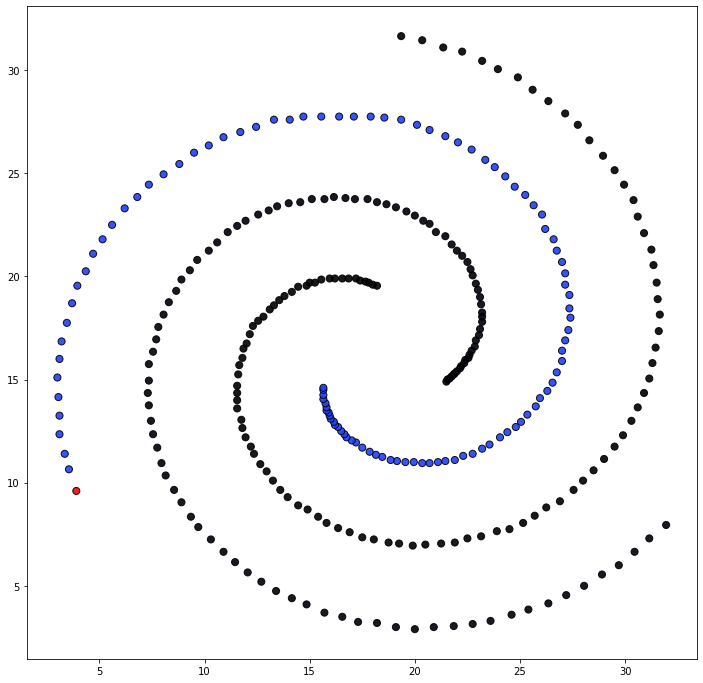

In [109]:
size=12
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=50, 
            c=np.array(list(cluster_dict_list[idx].values())),
            marker="o",
            cmap='flag',
            norm=None,
            alpha=.9,
            edgecolor="k")

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
frames = len(candidates)


outfile = filename + str(frames) + 'frames.gif'

if os.path.isfile(outfile):
    def init():
        scatter = ax.scatter(X[:, 0], X[:, 1],
                        s=40, 
                        c=np.array(list(cluster_dict_list[0].values())),
                        marker="o",
                        cmap='rainbow',
                        norm=None,
                        alpha=1,
                        edgecolor="k")
        #ax.set(xlim=(-1, 35), ylim=(-1, 35))

        return scatter,

    #collection = PatchCollection(X, animated=True)

    #ax.add_collection(collection)
    #ax.autoscale_view(True)

    def animate(i):

        scatter = ax.scatter(X[:, 0], X[:, 1],
                    s=40, 
                    c=np.array(list(cluster_dict_list[candidates[i]].values())),
                    marker="o",
                    cmap='flag',
                    norm=None,
                    alpha=1,
                    edgecolor="k")
        return scatter,



    ani = FuncAnimation(fig, animate,interval=1000,init_func=init,frames=frames,repeat=False, blit=True)

    #ani.save('animation.gif')



    #writer=animation.PillowWriter()

    #writer = animation.FFMpegWriter(fps=2,bitrate=1000)

    ani.save(outfile, dpi=200)
    fig.show()


In [ ]:
metrics.silhouette_score(X, pred, metric="euclidean")

%%time
length = len(cluster_dict_list)-1
silhouette_scores = []

for i in range(length):
    pred = np.array(list(cluster_dict_list[i].values()))
    silhouette_scores.append(metrics.silhouette_score(X, pred, metric="euclidean"))

In [ ]:
silhouette_list = []
for i in candidates:
    silhouette = metrics.silhouette_score(X,     np.array(list(cluster_dict_list[i].values())), metric="euclidean")
    silhouette_list.append(silhouette)

In [ ]:
plt.plot(silhouette_list)

In [ ]:
#idx = silhouette_scores.index(max(silhouette_scores[simplex_tree.num_vertices():idx]))
#print(idx)

In [ ]:
rand_score_list = []
true = y
for i in range(len(cluster_dict_list)):
    pred = np.array(list(cluster_dict_list[i].values()))
    rand_score = metrics.adjusted_rand_score( true, pred)
    rand_score_list.append(rand_score)

In [ ]:
 plt.plot(rand_score_list)

In [ ]:
max(rand_score_list)

In [ ]:
rand_score_list.index(max(rand_score_list))

In [ ]:
idx = rand_score_list.index(max(rand_score_list))
print(idx)

ValueError: 'tab10b' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

In [ ]:
def pogo(dataset):
    rips_complex = gudhi.RipsComplex(points=dataset,max_edge_length=100)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
    df = pd.DataFrame(simplex_tree.get_filtration(), columns=['simplex','distance'])
    #move through list and assign clusters to conected components

    point_dict={i:0 for i in range(simplex_tree.num_vertices())}
    counter=0

    cluster_dict_list = []
    for i in range(simplex_tree.num_vertices(),len(df)):
        #if both points are still in cluster 0, assign both to a new cluster
        if point_dict[df.loc[i,'simplex'][0]] == 0 and point_dict[df.loc[i,'simplex'][1]] == 0:
            counter += 1
            point_dict[df.loc[i,'simplex'][0]] = counter
            point_dict[df.loc[i,'simplex'][1]] = counter
            #if one point is in cluster 0 and one is not, assign the one in cluster 0 to the existing cluster
        elif point_dict[df.loc[i,'simplex'][0]] == 0 and point_dict[df.loc[i,'simplex'][1]] != 0:
            point_dict[df.loc[i,'simplex'][0]] = point_dict[df.loc[i,'simplex'][1]]

            #and vice versa
        elif point_dict[df.loc[i,'simplex'][0]] != 0 and point_dict[df.loc[i,'simplex'][1]] == 0:
            point_dict[df.loc[i,'simplex'][1]] = point_dict[df.loc[i,'simplex'][0]]

            #if both points are not in cluster 0 and not in the same cluster, merge clusters to the lower number cluster
        elif point_dict[df.loc[i,'simplex'][0]] != 0 and point_dict[df.loc[i,'simplex'][1]] != 0 and point_dict[df.loc[i,'simplex'][0]] != point_dict[df.loc[i,'simplex'][1]]:
            larger_cluster_number = max(point_dict[df.loc[i,'simplex'][0]], point_dict[df.loc[i,'simplex'][1]])
            smaller_cluster_number = min(point_dict[df.loc[i,'simplex'][0]], point_dict[df.loc[i,'simplex'][1]])
            for key, value in point_dict.items():
                if value == larger_cluster_number:
                    point_dict[key] = smaller_cluster_number
        cluster_dict_list.append(point_dict.copy())
        #print(point_dict)
        #print('step',i)

    
    cutoff_value = 0
    for i in range(len(cluster_dict_list)):
        if cutoff_value == 0:
            if all(value != 0 for value in cluster_dict_list[i].values()):
                cutoff_value = i
                print('dataset becomes connected at simplex #',cutoff_value)
       
    df = df[:cutoff_value]
    #cluster_dict_list =
    
    #find the gaps between birth/death pairs

    df['gaps'] = df['distance'] - df['distance'].shift(1)
    
    #find normalized distance
    scaler = MinMaxScaler()
    df['normed_distance'] = scaler.fit_transform(df['distance'].values.reshape(-1, 1))

    #Mulitply the gaps by their normed location in the filtration, weighting features more heavily if they're later
    df['normed_gaps'] = df['gaps'] * df['normed_distance']

    norm_sum = df['normed_gaps'].sum()
    df['probability_vector_normed_gaps'] = df['normed_gaps'] / norm_sum
    
    gap_sum = df['gaps'].sum()
    df['probability_vector_gaps'] = df['normed_gaps'] / gap_sum

    partition = 10
    candidates = [i for i in df.nlargest(partition ,['gaps']).index if i in df.nlargest( partition,['normed_gaps']).index]
    #print('possible cuttoffs' , candidates)
    idx = cutoff_value - 1
    #idx = candidates[0]
    print('idx' ,idx)

    print('your dataset appears to have', len(np.unique(np.array(list(cluster_dict_list[idx].values())))),'clusters')

    #print( np.array(list(cluster_dict_list[idx].values())))

    print(simplex_tree.num_vertices() , 'vertices')  
    print(simplex_tree.num_simplices(), 'simplices')
    print('dimension:', simplex_tree.dimension())

    size=10
    plt.figure(figsize=(size,size))
    plt.scatter(dataset[:, 0], dataset[:, 1],
                s=30, 
                c=np.array(list(cluster_dict_list[idx].values())),
                marker="o",
                cmap='rainbow',
                norm=None,
                alpha=.9,
                edgecolor="k")
    
    return cluster_dict_list, candidates, idx


In [ ]:
cluster_dict_list, candidates, idx = pogo(X)

In [ ]:
true = y
pred = np.array(list(cluster_dict_list[idx].values()))

print('adjusted rand score =' , metrics.adjusted_rand_score(true, pred))


In [ ]:
%matplotlib notebook

In [ ]:
frames = 30
interval = int(len(cluster_dict_list)/frames)
print(interval)


In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
frames = 30
interval = int(len(cluster_dict_list)/frames)
print(interval)

scatter = ax.scatter(X[:, 0], X[:, 1],
                s=40, 
                c=np.array(list(cluster_dict_list[0].values())),
                marker="o",
                cmap='gist_rainbow',
                norm=None,
                alpha=1,
                edgecolor="k")
ax.set(xlim=(-1, 35), ylim=(-1, 35))

def animate(n):
    scatter.set_array(np.array(list(cluster_dict_list[n*interval].values())))
    
ani = FuncAnimation(fig, animate,interval=20,frames=frames,repeat=True, blit=True)

#ani.save('animation.gif')



writer=animation.PillowWriter()

writer = animation.FFMpegWriter(fps=2,bitrate=1000)

ani.save('animation-d.mp4', writer=writer, dpi=250)


fig.show()

In [ ]:
dataset = np.loadtxt('D31.txt')

X, y = dataset[:, :2],dataset[:, 2]

size=12
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=25, 
            c=y,
            marker="o",
            cmap='tab10',
            norm=None,
            alpha=.7,
            edgecolor="k")